# Setup Nature Modules

## Introduction

<!-- 在这个教程里，我们将创建一个空间框，所有输入的数据都会被自动的重新调整到这个空间范围 -->

Create an example `xarray.DataArray` whose shape is (40 * 50).

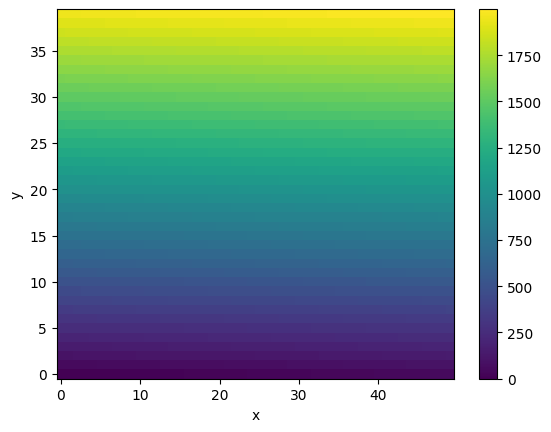

In [1]:
import xarray as xr
import numpy as np


data = xr.DataArray(data=np.arange(2000).reshape((40, 50)), dims=("y", "x"))
data.plot()

Create an `ABSESpy` model with 10 * 10 natural patch module.

In [2]:
from abses import MainModel

model = MainModel()
module = model.nature.create_module(how="from_resolution", shape=(10, 10))

model.summary()

Using ABSESpy version: v0.6.7


name     MainModel
state         init
tick             0
dtype: object

When apply raster of a `xarray.DataArray` to natural module, the raster will be automatically reprojected to the natural module's spatial extent.

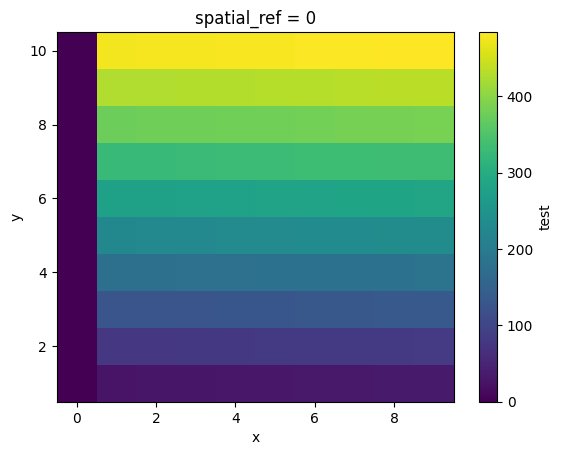

In [3]:
module.apply_raster(
    data, attr_name="test", cover_crs=True, resampling_method="bilinear"
)
ax = module.get_xarray("test").plot()

note: edge effect may exists when re-projecting the raster.

## Working with real data

Here, we have a demo of how to load climate data and apply it to the natural module. When loading the data, the data will be automatically reprojected to the natural module's spatial extent.

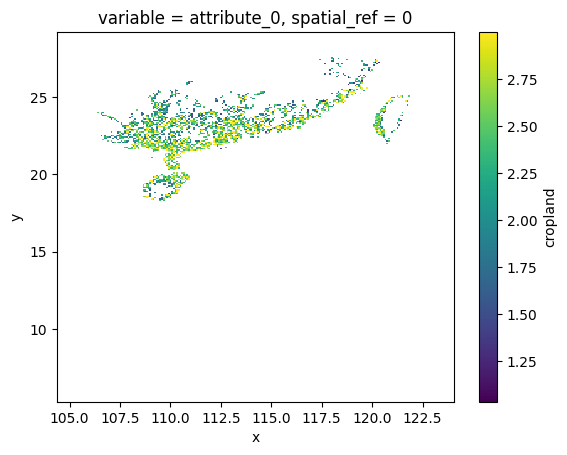

In [4]:
from abses import load_data

raster_path = load_data("farmland.tif")

cropland = model.nature.create_module(
    how="from_file",
    raster_file=raster_path,
    apply_raster=True,
    name="cropland",
)

cropland.get_xarray().plot()

In [5]:
data = xr.open_dataset(load_data("precipitation.nc"))
data

<xarray.Dataset> Size: 13MB
Dimensions:  (lat: 400, lon: 700, time: 12)
Coordinates:
  * lat      (lat) float32 2kB 15.05 15.15 15.25 15.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 3kB 70.05 70.15 70.25 70.35 ... 139.8 139.9 140.0
  * time     (time) datetime64[ns] 96B 2018-01-16T10:30:00 ... 2018-12-16T10:...
Data variables:
    prec     (time, lat, lon) float32 13MB ...
Attributes:
    Conventions:  CF-1.0
    history:      Created at 2016-04-02 14:55:55 UTC by the ITPCAS Data Fusio...
    source:       ITPCAS Data Fusion System (Version: 01.02.0240)
    institution:  Institute of Tibetan Plateau Research, Chinese Academy of S...
    title:        Monthly mean precipitation rate from the ITPCAS China Meteo...
    description:  Data from ITPCAS China Meteorological Forcing Dataset (Vers...
    references:   He, J., and K. Yang, 2011: China Meteorological Forcing Dat...

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 400, lon: 700)
Coordinates:
  * lat      (lat) float32 2kB 15.05 15.15 15.25 15.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 3kB 70.05 70.15 70.25 70.35 ... 139.8 139.9 140.0
    time     datetime64[ns] 8B 2018-01-16T10:30:00
Data variables:
    prec     (lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.0
    history:      Created at 2016-04-02 14:55:55 UTC by the ITPCAS Data Fusio...
    source:       ITPCAS Data Fusion System (Version: 01.02.0240)
    institution:  Institute of Tibetan Plateau Research, Chinese Academy of S...
    title:        Monthly mean precipitation rate from the ITPCAS China Meteo...
    description:  Data from ITPCAS China Meteorological Forcing Dataset (Vers...
    references:   He, J., and K. Yang, 2011: China Meteorological Forcing Dat...

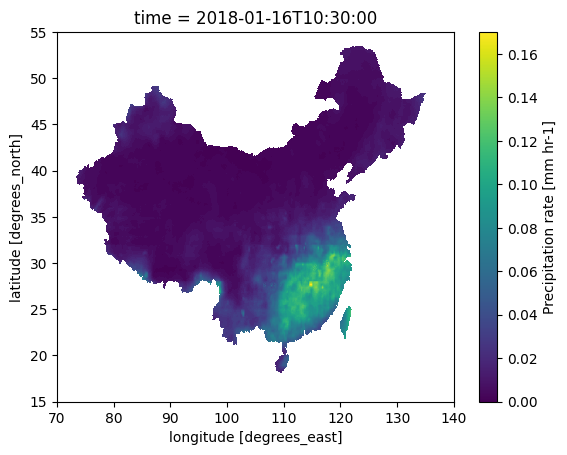

In [6]:
a_month = data.sel(time="2013-01", method="nearest")
a_month["prec"].plot()

a_month

When applying the raster data to an existing module, `ABSESpy` automatically project match it to the current `CRS`.

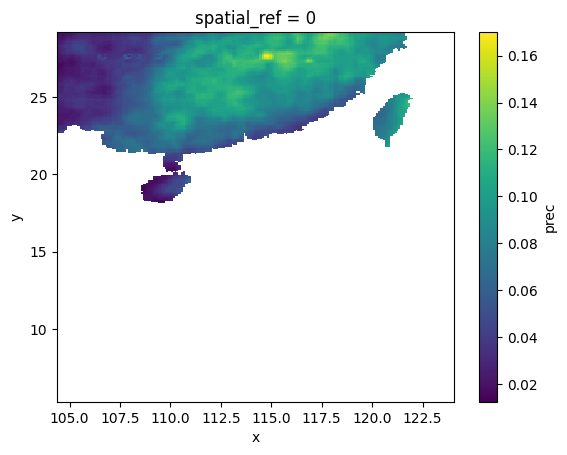

In [7]:
cropland.apply_raster(a_month, attr_name="prec", cover_crs=True)
cropland.get_xarray("prec").plot()

## Dynamic raster data

The `NetCDF` dataset has three dims: 'time', 'x'(longitude), and 'y'(latitude).

One benefit of using `ABSESpy` is to update the dataset by real-world time. Below is an example:

In [8]:
def update_precipitation(data, time):
    return data.sel(time=time.dt, method="nearest")


cropland.add_dynamic_variable(
    name="prec",
    data=data,
    function=update_precipitation,
    cover_crs=True,
)

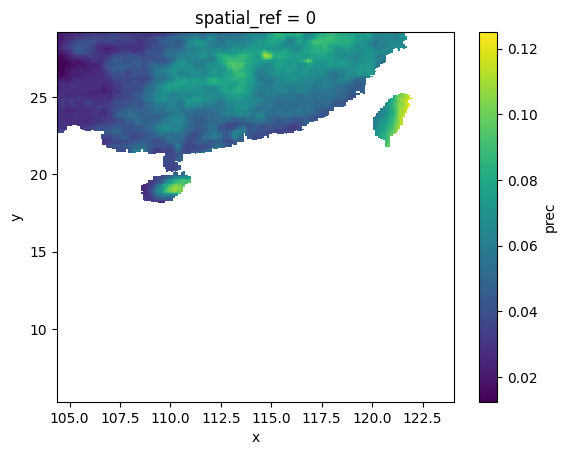

In [9]:
cropland.dynamic_var("prec", dtype="xarray").plot()

## Create Module from Vector Dataset

In this example, we will create a `PatchModule` and geo-agents with a `shapefile` dataset.

In [10]:
import geopandas as gpd

data_path = load_data("YR_cities.zip")
gdf = gpd.read_file(data_path)
gdf.head()

,City_ID,Ratio,area,Shaoefile_,Perfecture,Province_n,geometry
0,100,0.546595,3958.281245,128.0,C100,Henan,"POLYGON ((113.38580 35.47040, 113.39200 35.464..."
1,102,0.385113,15258.027194,170.0,C102,Henan,"POLYGON ((112.03220 35.04700, 112.03260 35.045..."
2,106,0.567869,4273.313471,197.0,C106,Henan,"POLYGON ((115.19540 36.20580, 115.19700 36.203..."
3,107,0.389969,9951.746614,215.0,C107,Henan,"POLYGON ((111.96140 35.07840, 111.96400 35.076..."
4,109,0.601268,8279.739196,290.0,C109,Henan,"POLYGON ((113.67120 35.83740, 113.67660 35.835..."


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

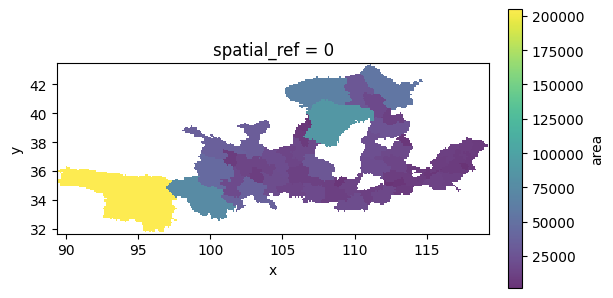

In [11]:
# Create a new model, and import the above GeoDataFrame as a patch module.
model = MainModel()
yr_basin = model.nature.create_module(
    how="from_vector",
    vector_file=gdf,
    resolution=0.1,  # 0.1 degree.
    major_layer=True,
    name="yellow_river",
    attr_name="area",
    apply_raster=True,
)
yr_basin.plot.show("area")

In [12]:
def update_precipitation(data, time):
    return data.sel(time=time.dt, method="nearest")


yr_basin.add_dynamic_variable(
    name="prec",
    data=data,
    function=update_precipitation,
    cover_crs=True,
)

In [13]:
from abses import Actor


class County(Actor):
    """City in the Yellow River Basin."""

    marker = "^"
    color = "#FFFF80"


model.agents.new_from_gdf(
    gdf,
    unique_id="City_ID",
    attrs=["area", "Province_n"],
)
yr_basin.random.new(County, num=50)

<ActorsList: (50)County>

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

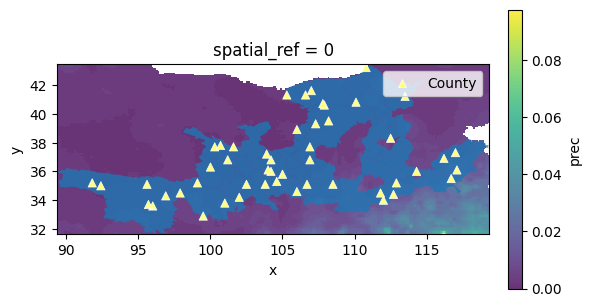

In [14]:
yr_basin.plot.show("prec")